QR-DQN adapted from: https://github.com/senya-ashukha/quantile-regression-dqn-pytorch/tree/master



In [1]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from collections import deque, namedtuple

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings

import logging

logging.getLogger("evotorch").disabled = True
logging.getLogger("evotorch").setLevel(logging.ERROR)  # or logging.CRITICAL

from QR_DQN_logger import Logger
from QR_DQN_rl_utils import huber # ReplayMemory, 

import os

from save_data_func import save_data


## Setup


In [2]:
nb_actions = None

Generate random seeds


In [3]:
random_seeds = [0, 8, 15]
# print("random_seeds ", type(random_seeds[0]), "\n")
nb_rep_episodes = len(random_seeds)


In [9]:
print("random_seeds ", random_seeds, "\n")


random_seeds  [0, 8, 15] 



Problem setup 


In [4]:
prob = "CartPole"
# prob = "Acrobot"
# prob = "MountainCar"
# prob = "LunarLander"

batch_size = 32


In [5]:
if prob == "CartPole":
    discrete = True
    # max_episodes = 100
    max_episodes = 300
    max_steps = 200
    
    nb_actions = 2
    
    env = gym.make('CartPole-v0', render_mode="rgb_array").unwrapped # To save time since 200 instead of 500 steps per episode
    
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    action_low = 0
    action_high = 1

    states_low = torch.tensor([-4.8, -torch.inf, -0.41887903, -torch.inf])
    states_high = torch.tensor([4.8, torch.inf, 0.41887903, torch.inf])


elif prob == "Acrobot":
    discrete = True
    max_episodes = 600
    max_steps = 200
    
    env = gym.make('Acrobot-v1', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    action_low = 0
    action_high = 2

    states_low = torch.tensor([-1, -1, -1, -1, -12.566371, -28.274334])
    states_high = torch.tensor([1, 1, 1, 1, 12.566371, 28.274334])

elif prob == "LunarLander": # ToDo
    discrete = True
    max_episodes = 400
    max_steps = 1000
    
    nb_actions = 3

    env = gym.make('LunarLander-v3', continuous=False, render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    action_low = 0
    action_high = 2

    states_low = torch.tensor([-2.5, -2.5, -10, -10, -6.2831855, -10, 0, 0])
    states_high = torch.tensor([2.5, 2.5, 10, 10, 6.2831855, 10, 1, 1])
    
elif prob == "MountainCar": # ToDo
    discrete = True
    max_episodes = 400
    max_steps = 200
    
    env = gym.make('MountainCar-v0', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    action_low = 0
    action_high = 3
    
    states_low = torch.tensor([-1.2, -0.07])
    states_high = torch.tensor([0.6, 0.07])



## QR-DQN



In [6]:
class Network(nn.Module):
    def __init__(self, len_state, num_quant, num_actions):
        nn.Module.__init__(self)
        
        self.num_quant = num_quant
        self.num_actions = num_actions
        
        self.layer1 = nn.Linear(len_state, 256)
        self.layer2 = nn.Linear(256, num_actions*num_quant)  

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x.view(-1, self.num_actions, self.num_quant)
    
    def select_action(self, state, eps):
        if not isinstance(state, torch.Tensor): 
            state = torch.Tensor([state])    
        action = torch.randint(0, 2, (1,))
        if random.random() > eps:
            action = self.forward(state).mean(2).max(1)[1]
        return int(action)


In [7]:
def start_QR_DQN(prob, max_episodes, max_steps, seed, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN):
    
    episode_reward_list = []
    
    # print("seed ", seed, "\n")
    # print("env ", env, '\n')
    
    steps_done = 0

    for episode in range(max_episodes):
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        # is_success_bool = False # For Panda Gym envs
        done = False
        actions_list = []
        
        # for step in tqdm(range(max_steps)):
        for step in range(max_steps):
            
            steps_done += 1
            
            action = Z.select_action(torch.Tensor([state]), eps(steps_done))

            action = int(action)
            actions_list.append(action)
            
            # Apply the first action from the optimized sequence
            next_state, reward, done, terminated, info = env.step(action)
            
            memory_QR_DQN.push(state, torch.Tensor([action]), next_state, reward, float(done))
            
            episode_reward += reward
            
            if len(memory_QR_DQN) < batch_size: pass # break
            else:
                # Sample a batch of transitions from replay memory
                states, actions, rewards, next_states, dones = memory_QR_DQN.sample(batch_size)
                # Predicted Q-values for the sampled state-action pairs
                theta = Z(states)[np.arange(batch_size), actions]
                
                # Q-values for the next states using target network
                Znext = Ztgt(next_states).detach()
                # Maximum Q-value for the next states using target network
                Znext_max = Znext[np.arange(batch_size), Znext.mean(2).max(1)[1]]
                
                # Reshape rewards and dones to have shape (batch_size, 1)
                rewards = rewards.view(-1,1)
                dones = dones.view(-1, 1)
                
                # print(rewards.shape, dones.shape, Znext_max.shape, "\n")
                
                # Target value
                Ttheta = rewards + gamma_QR_DQN * (1 - dones) * Znext_max
                # Quantile Huber loss calculation
                diff = Ttheta.t().unsqueeze(-1) - theta 
                loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()
                loss = loss.mean()

                # Model gradient descent update
                optimizer_QR_DQN.zero_grad()
                loss.backward()
                optimizer_QR_DQN.step()
            
            # Target network update
            if step % 100 == 0:
                Ztgt.load_state_dict(Z.state_dict())
            
            done = done or terminated
            if done:
                # nb_episode_success += 1
                # running_reward = episode_reward  if not running_reward else 0.2 * episode_reward + running_reward*0.8
                break
            
            state = np.copy(next_state).reshape(state_dim)
        
        # episode_reward_list_withASGNN[episode] = episode_reward
        episode_reward_list.append(episode_reward)

    return episode_reward_list

    

In [8]:
def main_QR_DQN(prob, max_episodes, max_steps, random_seeds, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN):
    
    episode_rep_rewards = np.zeros((nb_rep_episodes, max_episodes))
        
    for rep_ep in tqdm(range(nb_rep_episodes)):
        seed = int(random_seeds[rep_ep]) # Seed for episode
        
        episode_reward_list = start_QR_DQN(prob, max_episodes, max_steps, seed, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN)
        
        episode_rep_rewards[rep_ep] = np.array(episode_reward_list).reshape(max_episodes)
        
    mean_episode_rep_rewards = np.mean(episode_rep_rewards, axis=0)
    std_episode_rep_rewards = np.std(episode_rep_rewards, axis=0)

    return episode_rep_rewards, mean_episode_rep_rewards, std_episode_rep_rewards
    
    

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # return random.sample(self.memory, batch_size)
        
        # Sample a batch of transitions
        transitions = random.sample(self.memory, batch_size)
        # Unzip the batch into separate components
        batch = Transition(*zip(*transitions))

        # Convert each component to a tensor
        states = torch.tensor(batch.state, dtype=torch.float32)
        actions = torch.tensor([a.item() if isinstance(a, torch.Tensor) else a for a in batch.action], dtype=torch.long)
        rewards = torch.tensor(batch.reward, dtype=torch.float32)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32)
        dones = torch.tensor(batch.done, dtype=torch.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)




In [10]:
if discrete:
    Z = Network(len_state=len(env.reset()[0]), num_quant=2, num_actions=env.action_space.n)
    Ztgt = Network(len_state=len(env.reset()[0]), num_quant=2, num_actions=env.action_space.n)
    optimizer_QR_DQN = optim.Adam(Z.parameters(), 1e-3)
    
    memory_QR_DQN = ReplayMemory(10000)
    logger_QR_DQN = Logger('q-net', fmt={'loss': '.5f'})
    
    eps_start, eps_end, eps_dec = 0.9, 0.1, 500 
    eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)
    gamma_QR_DQN, batch_size_QR_DQN = 0.99, 32
    tau = torch.Tensor((2 * np.arange(Z.num_quant) + 1) / (2.0 * Z.num_quant)).view(1, -1)

    episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN, std_episode_rep_rewards_QR_DQN = main_QR_DQN(prob, max_episodes, max_steps, random_seeds, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN)



100%|██████████| 3/3 [09:53<00:00, 197.71s/it]


In [11]:
method_name = "QR_DQN"
save_data(prob, method_name, episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN, std_episode_rep_rewards_QR_DQN)



In [12]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")


episode_rep_rewards_QR_DQN  [array([29., 19., 12., 11., 39., 22., 24., 20., 23., 26., 23., 26., 50.,
       57., 28., 40., 46., 29., 28., 23., 23., 14., 36., 34., 35., 28.,
       30., 22., 29., 19., 17., 23., 20., 16., 14., 18., 13., 13., 22.,
       11., 13., 13., 15., 10., 12., 13.,  9., 10., 11., 10.,  8.,  8.,
        8.,  8.,  8.,  9.,  8.,  9.,  8.,  8.,  8.,  8., 12.,  9.,  8.,
        8.,  8., 11.,  8.,  8.,  8., 11., 10.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8., 11.,  8., 10.,  8., 10., 10., 10.,  8.,
        8.,  8.,  8.,  9.,  9.,  8.,  9., 11.,  8.,  8.,  8., 12., 11.,
        8.,  8.,  8.,  8.,  8.,  8., 11.,  8.,  8.,  9.,  8.,  8., 10.,
       12.,  9.,  8.,  8., 10.,  8.,  8.,  8., 10.,  8.,  9., 11., 11.,
       12., 12., 11., 13., 14., 14., 12., 13., 15., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 15., 15., 14., 17., 15., 17., 14., 13.,
       17., 16., 17., 18., 16., 16., 14., 14., 18., 16., 16., 17., 17.,
       18., 18., 17., 16., 16., 15.

## Plots for each discrete action space environment



- Lunar lander

1000 steps per episode


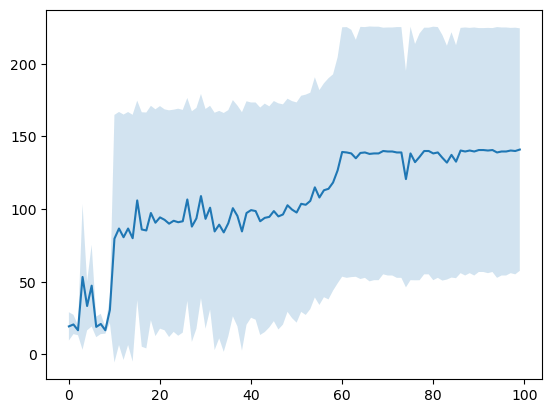

In [ ]:
if prob == "LunarLander":
    plt.plot(mean_episode_rep_rewards_QR_DQN)
    plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [ ]:
if prob == "LunarLander":
    print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
    print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
    print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Cart pole

200 steps per episode


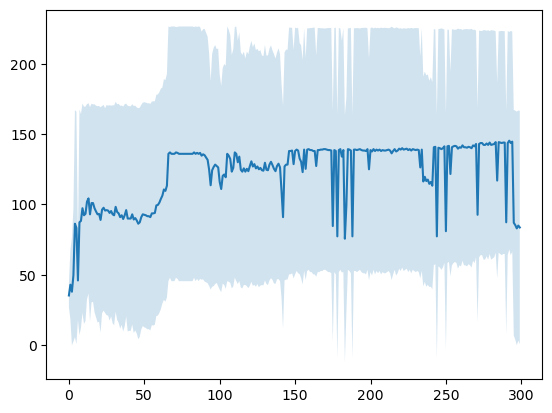

In [13]:
if prob == "CartPole":
    plt.plot(mean_episode_rep_rewards_QR_DQN)
    plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [14]:
if prob == "CartPole":
    print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
    print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
    print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([29., 19., 12., 11., 39., 22., 24., 20., 23., 26., 23., 26., 50.,
       57., 28., 40., 46., 29., 28., 23., 23., 14., 36., 34., 35., 28.,
       30., 22., 29., 19., 17., 23., 20., 16., 14., 18., 13., 13., 22.,
       11., 13., 13., 15., 10., 12., 13.,  9., 10., 11., 10.,  8.,  8.,
        8.,  8.,  8.,  9.,  8.,  9.,  8.,  8.,  8.,  8., 12.,  9.,  8.,
        8.,  8., 11.,  8.,  8.,  8., 11., 10.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8., 11.,  8., 10.,  8., 10., 10., 10.,  8.,
        8.,  8.,  8.,  9.,  9.,  8.,  9., 11.,  8.,  8.,  8., 12., 11.,
        8.,  8.,  8.,  8.,  8.,  8., 11.,  8.,  8.,  9.,  8.,  8., 10.,
       12.,  9.,  8.,  8., 10.,  8.,  8.,  8., 10.,  8.,  9., 11., 11.,
       12., 12., 11., 13., 14., 14., 12., 13., 15., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 15., 15., 14., 17., 15., 17., 14., 13.,
       17., 16., 17., 18., 16., 16., 14., 14., 18., 16., 16., 17., 17.,
       18., 18., 17., 16., 16., 15.

- Acrobot

200 steps per episode


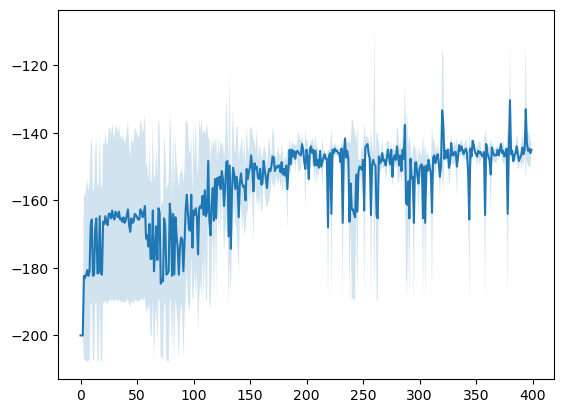

In [ ]:
if prob == "Acrobot":
    plt.plot(mean_episode_rep_rewards_QR_DQN)
    plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [ ]:
if prob == "Acrobot":
    print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
    print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
    print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Moutain car

200 steps per episode


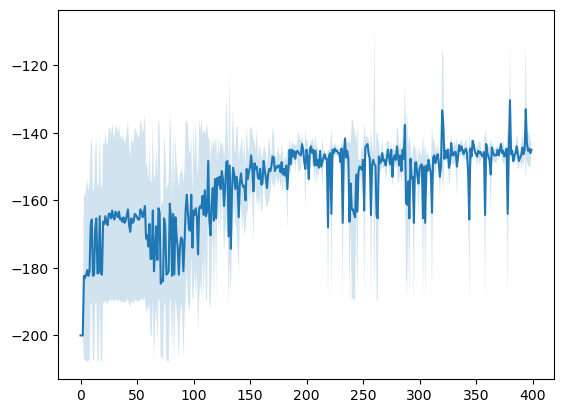

In [ ]:
if prob == "MountainCar":
    plt.plot(mean_episode_rep_rewards_QR_DQN)
    plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [ ]:
if prob == "MountainCar":
    print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
    print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
    print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.